In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
# ^^^ pyforest auto-imports - don't write above this line
# scRNA-seq analysis in Python

The tutorial is similar to the one for Seurat and can be found at

https://scanpy-tutorials.readthedocs.io/en/latest/pbmc3k.html

## Load libraries we will use

In [2]:
import numpy as np
import pandas as pd
import scanpy as sc

We turn off some distracting warnings

In [3]:
import warnings

warnings.simplefilter('ignore', FutureWarning)
warnings.simplefilter('ignore', UserWarning)

## Note on `scanpy` submodules

The naming of submodules is very terse and somewhat cryptic. Here is a guide to the submodules used in this tutorial.

- `tl` tools
- `pp` preprocessing
- `pl` plotting

## Download and prepare data

Here we assume that you have completed the 10X CellRanger pipeline to generate the count of matrices.

In [4]:
%%capture
%%bash

DIR=data
FILENAME=pbmc3k_filtered_gene_bc_matrices.tar.gz
if [ ! -f $DIR/$FILENAME ]; then
    mkdir $DIR
    wget https://bit.ly/3xbiCSz -O $DIR/$FILENAME
    cd $DIR
    tar -xzf $FILENAME
fi

Inspect the data files downloaded. The files of interest are in `data/filtered_gene_bc_matrices/hg19` and consist of

- `barcodes.tsv` A list of the 2,700 barcodes used, where each barcode represents a cell
- `genes.tsv` A mapping of gene IDs to gene symbols    
- `matrix.mtx` A matrix containing the UMI count per cell and gene combination

In [5]:
ls -R data

atlas_mouse.h5ad
filtered_gene_bc_matrices/
pbmc3k_filtered_gene_bc_matrices.tar.gz

data/filtered_gene_bc_matrices:
hg19/

data/filtered_gene_bc_matrices/hg19:
barcodes.tsv  genes.tsv     matrix.mtx


In [6]:
! wc -l data/filtered_gene_bc_matrices/hg19/barcodes.tsv
! head -3 data/filtered_gene_bc_matrices/hg19/barcodes.tsv

    2700 data/filtered_gene_bc_matrices/hg19/barcodes.tsv
AAACATACAACCAC-1
AAACATTGAGCTAC-1
AAACATTGATCAGC-1


In [7]:
! wc -l data/filtered_gene_bc_matrices/hg19/genes.tsv
! head -3 data/filtered_gene_bc_matrices/hg19/genes.tsv

   32738 data/filtered_gene_bc_matrices/hg19/genes.tsv
ENSG00000243485	MIR1302-10
ENSG00000237613	FAM138A
ENSG00000186092	OR4F5


#### Create a symbol to name lookup table

In [8]:
lut = pd.read_table('data/filtered_gene_bc_matrices/hg19/genes.tsv', 
                    header=None)
lut.columns = ['symbol', 'name']
lut = lut.set_index('symbol')
lut.head()

name
symbol                       
ENSG00000243485    MIR1302-10
ENSG00000237613       FAM138A
ENSG00000186092         OR4F5
ENSG00000238009  RP11-34P13.7
ENSG00000239945  RP11-34P13.8

The first line just reports the number of lines in `genes.tsv`, `barcodes.tsv` and `matrix.mtx` respectively. Subsequent lines are read as follows

- First column is gene_id given as line number in `genes.tsv`
- Second column is cell_id given as line number in `barcodes.tsv`
- Third column is UMI count for that cell/gene combination

Note that this particular organization is space-saving for sparse matrices. If we created a regular matrix of cells $\times$ genes, most entries would be filled by zeros.

In [9]:
! wc -l data/filtered_gene_bc_matrices/hg19/matrix.mtx
! head -5 data/filtered_gene_bc_matrices/hg19/matrix.mtx

 2286887 data/filtered_gene_bc_matrices/hg19/matrix.mtx
%%MatrixMarket matrix coordinate real general
%
32738 2700 2286884
32709 1 4
32707 1 1


Create output file store results

In [10]:
! mkdir write

mkdir: write: File exists


In [11]:
results_file = 'write/pbmc3k.h5ad'

### Read data into an Annotated Data file format

The variable name in the annotated table can come be the gene ID or gene symbol. If using the gene symbol, we need to make sure they are unique.

See [Annotated Data documentation](https://anndata.readthedocs.io/en/latest/index.html) for details of this data format.

```python
adata = sc.read_10x_mtx(
    'data/filtered_gene_bc_matrices/hg19/',  
    var_names='gene_ids', 
    cache=True) 
```

In [12]:
adata = sc.read_10x_mtx(
    'data/filtered_gene_bc_matrices/hg19/',  
    var_names='gene_symbols',          
    cache=True) 
adata.var_names_make_unique()

Note that the matrix is organized as cells (rows) $\times$ genes (cols)

In [13]:
# adata.var['gene_names'] = adata.var['gene_ids'].keys()

### Preprocessing

#### Inspect top gens

Top genes by normalized counts across cells

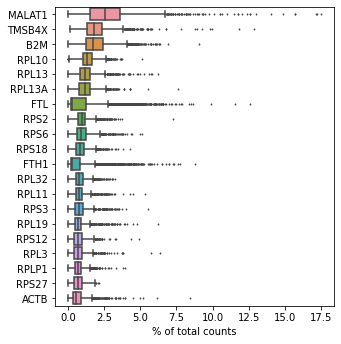

In [14]:
sc.pl.highest_expr_genes(adata, n_top=20)

#### Filter by gene and cell count

The most basic filters specify how many non-zero count genes you need to accept a cell, and how many cells have non-zero counts to accept a gene.

In [15]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

#### Filter by mitochondrial gene proportion

Damaged or dead cells lose cytoplasmic RNA more easily than mitochondrial RNA, so a high proportion of mitochondrial genes is an indicator of a poor quality cell.

`sc.pp.calculate_qc_metrics` adds multiple metrics to the annotated data set that can be used for custom QC based on user-defined QC variables.

Observation level metrics include:
```
`total_{var_type}_by_{expr_type}`
    E.g. "total_genes_by_counts". Number of genes with positive counts in a cell.
`total_{expr_type}`
    E.g. "total_counts". Total number of counts for a cell.
`pct_{expr_type}_in_top_{n}_{var_type}` – for `n` in `percent_top`
    E.g. "pct_counts_in_top_50_genes". Cumulative percentage of counts
    for 50 most expressed genes in a cell.
`total_{expr_type}_{qc_var}` – for `qc_var` in `qc_vars`
    E.g. "total_counts_mito". Total number of counts for variabes in
    `qc_vars`.
`pct_{expr_type}_{qc_var}` – for `qc_var` in `qc_vars`
    E.g. "pct_counts_mito". Proportion of total counts for a cell which
    are mitochondrial.
```

Variable level metrics include:
```
`total_{expr_type}`
    E.g. "total_counts". Sum of counts for a gene.
`mean_{expr_type}`
    E.g. "mean counts". Mean expression over all cells.
`n_cells_by_{expr_type}`
    E.g. "n_cells_by_counts". Number of cells this expression is
    measured in.
`pct_dropout_by_{expr_type}`
    E.g. "pct_dropout_by_counts". Percentage of cells this feature does
    not appear in.
```

In [16]:
adata.var['mt'] = adata.var_names.str.startswith('MT-')
sc.pp.calculate_qc_metrics(
    adata, 
    qc_vars=['mt'], 
    percent_top=None, 
    log1p=False, 
    inplace=True)

Violin pots are distribution (histogram) plots flipped on their side and duplicated for bilateral symmetry.

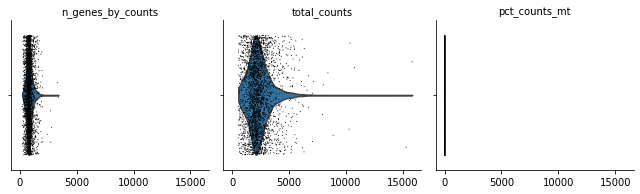

In [17]:
sc.pl.violin(
    adata, 
    keys=['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
    jitter=0.4, 
    multi_panel=True)

#### Before custom filter

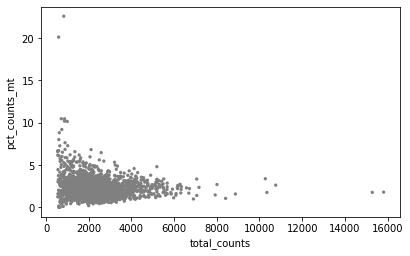

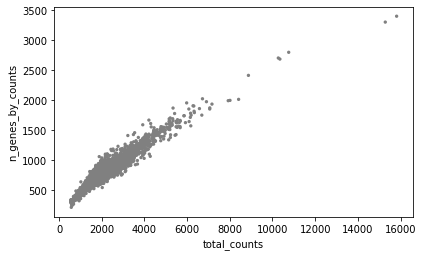

In [18]:
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

#### Filter data

In [19]:
adata = adata[adata.obs.n_genes_by_counts < 2500, :]
adata = adata[adata.obs.pct_counts_mt < 5, :]

#### After custom filter

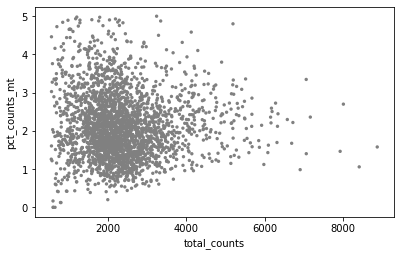

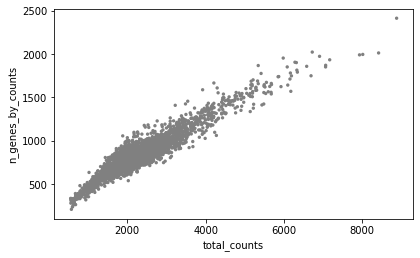

In [20]:
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

### Normalize

Normalize to 10,000 reads per cell so that comparisons can be made.

In [21]:
sc.pp.normalize_total(adata, target_sum=1e4)

### Create log counts

In [22]:
sc.pp.log1p(adata)

### Find highly variable genes

In [23]:
sc.pp.highly_variable_genes(
    adata, 
    min_mean=0.0125, 
    max_mean=3, 
    min_disp=0.5)

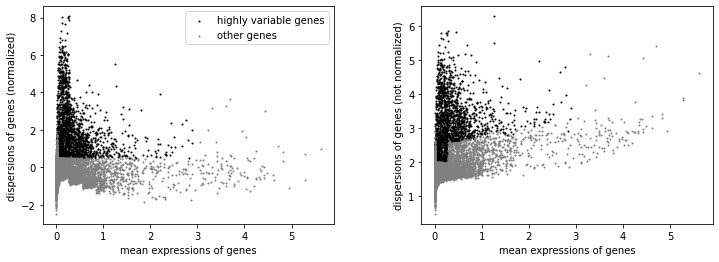

In [24]:
sc.pl.highly_variable_genes(adata)

The list of highly variable genes is stored as a Boolean vector in `var.highly_variable`. We can inspect these genes if we want to by Boolean filtering.

In [25]:
adata.var.highly_variable[:5]

AL627309.1       False
AP006222.2       False
RP11-206L10.2    False
RP11-206L10.9    False
LINC00115        False
Name: highly_variable, dtype: bool

In [26]:
adata.var[adata.var.highly_variable == True][:5]

gene_ids  n_cells     mt  n_cells_by_counts  mean_counts  \
TNFRSF4  ENSG00000186827      155  False                155     0.077407   
CPSF3L   ENSG00000127054      202  False                202     0.094815   
ATAD3C   ENSG00000215915        9  False                  9     0.009259   
C1orf86  ENSG00000162585      501  False                501     0.227778   
RER1     ENSG00000157916      608  False                608     0.298148   

         pct_dropout_by_counts  total_counts  highly_variable     means  \
TNFRSF4              94.259259         209.0             True  0.277410   
CPSF3L               92.518519         256.0             True  0.385194   
ATAD3C               99.666667          25.0             True  0.038252   
C1orf86              81.444444         615.0             True  0.678283   
RER1                 77.481481         805.0             True  0.814813   

         dispersions  dispersions_norm  
TNFRSF4     2.086050          0.665406  
CPSF3L      4.506987          2.955005  
ATAD3C      3.953486          4.352607  
C1orf86     2.713522          0.543183  
RER1        3.447533          1.582528

### PCA

Many genes in co-regulated pathways are likely to vary in the same way, and hence provide redundant information. PCA is a method to reduce linear redundancy and is often used as a first step in dimension reduction.

In [27]:
sc.tl.pca(adata, svd_solver='arpack')

See how much each PC contributes to total variance. From the plot, we see that beyond the first 10 or so PCs, there are diminishing returns. When plotting on the log scale, the variance contributed is $e^y$ where $y$ is the value shown on the log scale. For example, $e^{-3}$ corresponds to approximately 0.05.

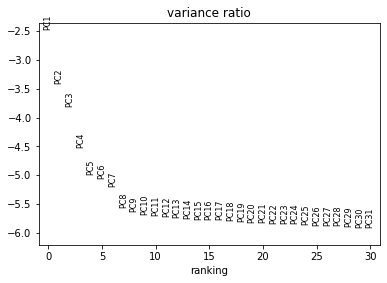

In [28]:
sc.pl.pca_variance_ratio(adata, log=True)

We make a plot in the PC1 and PC2 coordinates and color by the normalized count of the gene CST3 (Cystatin C)

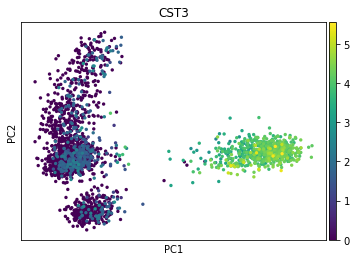

In [29]:
sc.pl.pca(adata, color='CST3', gene_symbols='gene_names')

We can see by inspection that `adata` is now a richer data structure.

In [30]:
adata

AnnData object with n_obs × n_vars = 2638 × 13714
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

Save the results to file. The file is stored in `HDF5` format, a hierarchical file format commonly used to store scientific data sets.

In [31]:
adata.write(results_file)

### Compute neighborhood graph

This essentially creates a distance matrix between cells, using the PCA coordinates for each cell. Here we use values that Seurat uses.

The `scanpy` defaults are `n_neighbors` = 10 and `n_pcs` = # of PC dimensions (default = 50).

In [32]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)

### Uniform mapping approximation and projection (UNAP)

In [33]:
sc.tl.umap(adata)

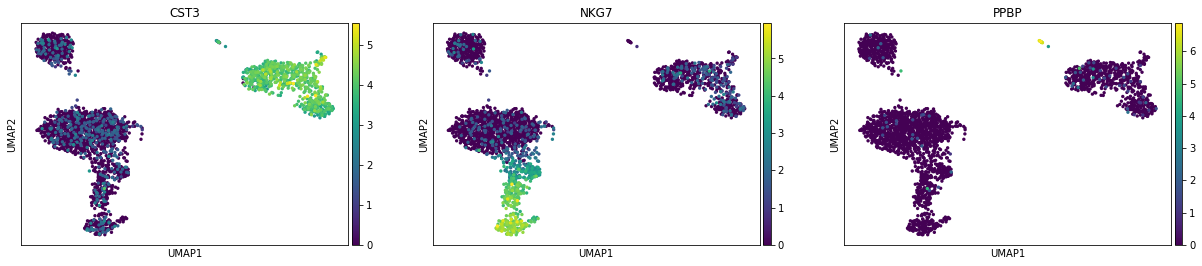

In [34]:
sc.pl.umap(adata, color=['CST3', 'NKG7', 'PPBP'])

### t-stochastic neighbor embedding (t-sne)

In [35]:
sc.tl.tsne(adata)

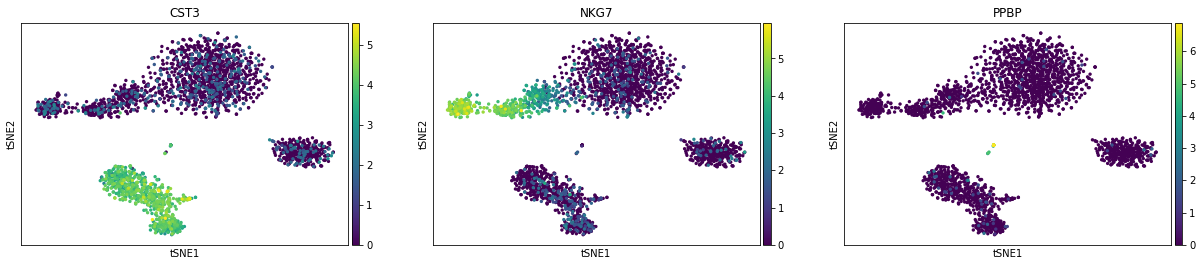

In [36]:
sc.pl.tsne(adata, color=['CST3', 'NKG7', 'PPBP'])

### Clustering with Leiden

In [37]:
sc.tl.leiden(adata)

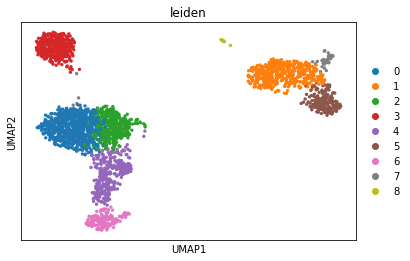

In [38]:
sc.pl.umap(adata, color='leiden')

### Clustering with Louvain

In [39]:
sc.tl.louvain(adata)

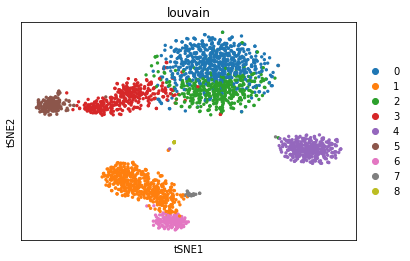

In [40]:
sc.pl.tsne(adata, color='louvain')

### Finding signature genes

We can run simple statistical tests to identify genes that are differentially expressed across clusters, or "signature" genes. There are also more sophisticated methods.

Results of calling `rank_genes_groups` are stored in `.uns['rank_genes_groups']` (`uns` is short for unstructured)

In [41]:
sc.tl.rank_genes_groups(adata, groupby='leiden', method='wilcoxon')

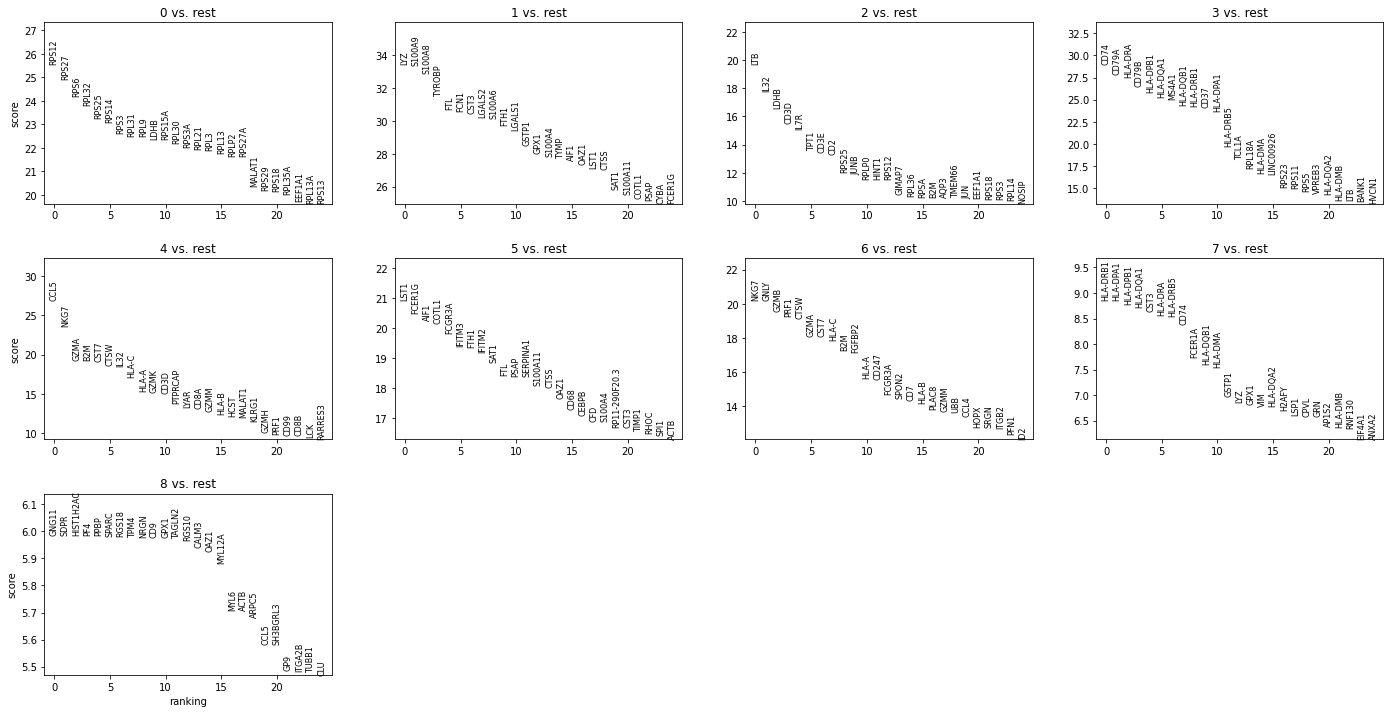

In [42]:
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

#### Where are the results stored?

In [43]:
adata.uns['rank_genes_groups'].keys()

dict_keys(['params', 'names', 'scores', 'pvals', 'pvals_adj', 'logfoldchanges'])

Look at the top 5 genes for each of the 9 clusters found by `leiden`

In [44]:
markers = (
    pd.DataFrame(adata.uns['rank_genes_groups']['names']).
    head(5)
)

In [45]:
markers

0       1     2         3     4       5     6         7          8
0  RPS12     LYZ   LTB      CD74  CCL5    LST1  NKG7  HLA-DRB1      GNG11
1  RPS27  S100A9  IL32     CD79A  NKG7  FCER1G  GNLY  HLA-DPA1       SDPR
2   RPS6  S100A8  LDHB   HLA-DRA  GZMA    AIF1  GZMB  HLA-DPB1  HIST1H2AC
3  RPL32  TYROBP  CD3D     CD79B   B2M   COTL1  PRF1  HLA-DQA1        PF4
4  RPS25     FTL  IL7R  HLA-DPB1  CST7  FCGR3A  CTSW      CST3       PPBP

### Save marker genes

In [46]:
marker_genes = list(set(markers.values.ravel()))
marker_genes

['LTB',
 'CD79A',
 'GZMA',
 'CST7',
 'RPS12',
 'GNLY',
 'LYZ',
 'FCER1G',
 'TYROBP',
 'PRF1',
 'HLA-DQA1',
 'PPBP',
 'COTL1',
 'CTSW',
 'HLA-DPB1',
 'HLA-DPA1',
 'PF4',
 'HIST1H2AC',
 'LDHB',
 'GZMB',
 'AIF1',
 'RPS25',
 'CD79B',
 'RPS27',
 'S100A8',
 'GNG11',
 'CD3D',
 'FTL',
 'CST3',
 'NKG7',
 'SDPR',
 'IL7R',
 'HLA-DRB1',
 'LST1',
 'IL32',
 'RPS6',
 'B2M',
 'S100A9',
 'CCL5',
 'HLA-DRA',
 'RPL32',
 'FCGR3A',
 'CD74']

#### Compare expression of top 5 genes in group 0 with the rest

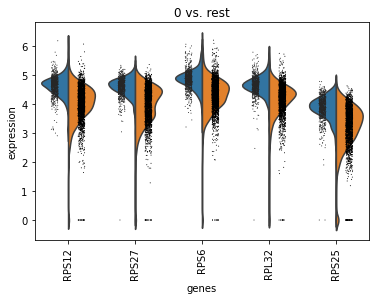

In [47]:
sc.pl.rank_genes_groups_violin(
    adata, 
    groups='0', 
    n_genes=5,
)

#### Compare expression of 3 selected genes across all clusters

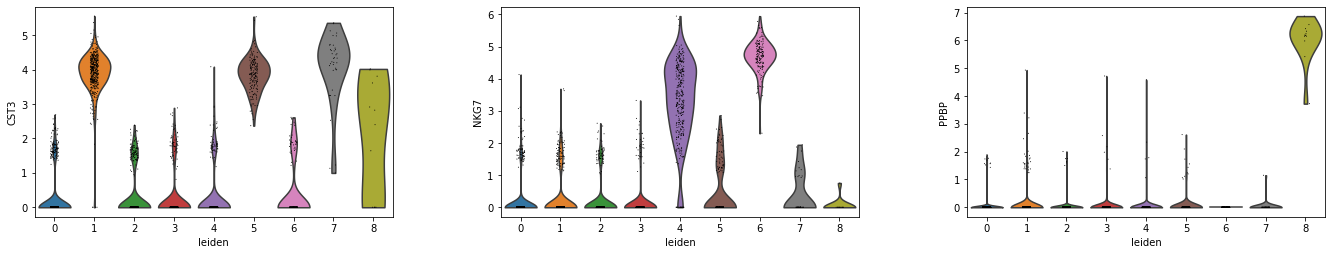

In [48]:
keys = ['CST3', 'NKG7', 'PPBP']
sc.pl.violin(adata, 
             keys,
             groupby='leiden')

#### Manual marking of cell types

In [49]:
%%bash 

if [ ! -d SCSA ]; then
    git clone --quiet https://github.com/bioinfo-ibms-pumc/SCSA.git
fi

In [50]:
result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names
dat = pd.DataFrame({group + '_' + key[:1]: result[key][group] 
                    for group in groups 
                    for key in ['names', 'logfoldchanges','scores','pvals']})
dat.to_csv("SCSA/scanpy_pbmc_3k.csv")

In [51]:
%%bash 

cd SCSA
python3 SCSA.py --noprint -d whole.db -i scanpy_pbmc_3k.csv \
    -s scanpy -E -f1.5 -p 0.01 -o result -m txt 

Version V1.1 [2020/07/03]
DB load: 47347 3 3 48257 37440
Namespace(Gensymbol=True, MarkerDB=None, celltype='normal', cluster='all', db='whole.db', foldchange=1.5, input='scanpy_pbmc_3k.csv', list_tissue=False, noprint=True, norefdb=False, outfmt='txt', output='result', pvalue=0.01, source='scanpy', species='Human', target='cellmarker', tissue='All', weight=100.0)
Version V1.1 [2020/07/03]
DB load: 47347 3 3 48257 37440
load markers: 45409
Cluster 0 Gene number: 33
Other Gene number: 936
Cluster 1 Gene number: 334
Other Gene number: 866
Cluster 2 Gene number: 34
Other Gene number: 934
Cluster 3 Gene number: 119
Other Gene number: 879
Cluster 4 Gene number: 45
Other Gene number: 945
Cluster 5 Gene number: 424
Other Gene number: 783
Cluster 6 Gene number: 161
Other Gene number: 864
Cluster 7 Gene number: 221
Other Gene number: 873
Cluster 8 Gene number: 131
Other Gene number: 877
#Cluster Type Celltype Score Times
['0', 'Good', 'T cell', 6.128258452638213, 2.1080909906831136]
['1', '?', '

In [52]:
df = pd.read_csv('SCSA/result', sep='\t')

In [53]:
df

Cell Type   Z-score  Cluster
0                          T cell  6.128258        0
1             Natural killer cell  2.907018        0
2                    Naive T cell  2.847514        0
3     Natural killer T (NKT) cell  2.409033        0
4                        Monocyte  2.243792        0
...                           ...       ...      ...
1043             Limbal stem cell -0.341467        8
1044                   Neutrophil -0.341467        8
1045                   Macrophage -0.345274        8
1046                    Beta cell -0.345330        8
1047               Endocrine cell -0.345330        8

[1048 rows x 3 columns]

In [54]:
df = df.loc[df.groupby('Cluster')['Z-score'].idxmax()].reset_index(drop=True)

In [55]:
df

Cell Type    Z-score  Cluster
0               T cell   6.128258        0
1             Monocyte   8.369135        1
2               T cell   7.304173        2
3               B cell  11.014281        3
4  Natural killer cell   4.682867        4
5             Monocyte   6.868238        5
6  Natural killer cell   9.159950        6
7             Monocyte   4.931193        7
8        Megakaryocyte   6.850169        8

In [56]:
df['unique_name'] = df['Cell Type'] + '-' + df['Cluster'].astype('str')

In [57]:
df

Cell Type    Z-score  Cluster            unique_name
0               T cell   6.128258        0               T cell-0
1             Monocyte   8.369135        1             Monocyte-1
2               T cell   7.304173        2               T cell-2
3               B cell  11.014281        3               B cell-3
4  Natural killer cell   4.682867        4  Natural killer cell-4
5             Monocyte   6.868238        5             Monocyte-5
6  Natural killer cell   9.159950        6  Natural killer cell-6
7             Monocyte   4.931193        7             Monocyte-7
8        Megakaryocyte   6.850169        8        Megakaryocyte-8

In [58]:
df.unique_name.to_list()

['T cell-0',
 'Monocyte-1',
 'T cell-2',
 'B cell-3',
 'Natural killer cell-4',
 'Monocyte-5',
 'Natural killer cell-6',
 'Monocyte-7',
 'Megakaryocyte-8']

In [59]:
adata.rename_categories('leiden', df.unique_name.to_list())

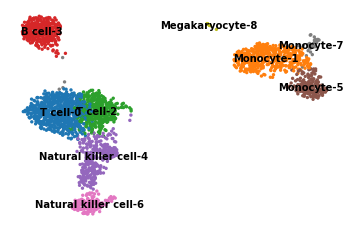

In [60]:
sc.pl.umap(adata, 
           color='leiden', 
           legend_loc='on data',
           title='', 
           frameon=False, 
           save='.pdf')

#### Gene expression for selected genes across all cells

- each column is a cell
- each row is a gene
- gene expression is represented by height

In [61]:
sc.tl.dendrogram(adata, groupby='leiden')

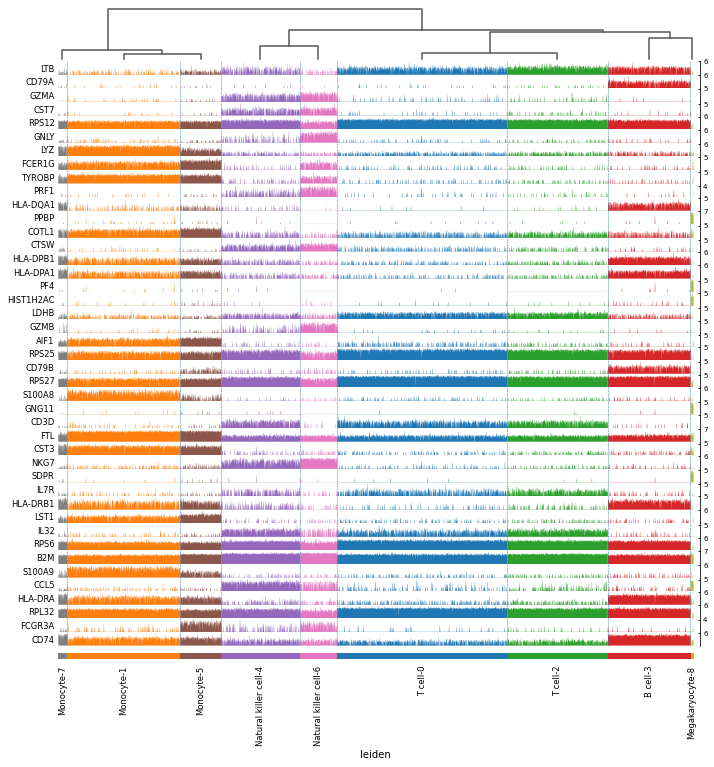

In [62]:
sc.pl.tracksplot(adata, marker_genes, groupby='leiden', dendrogram=True)

#### Visualize marker genes

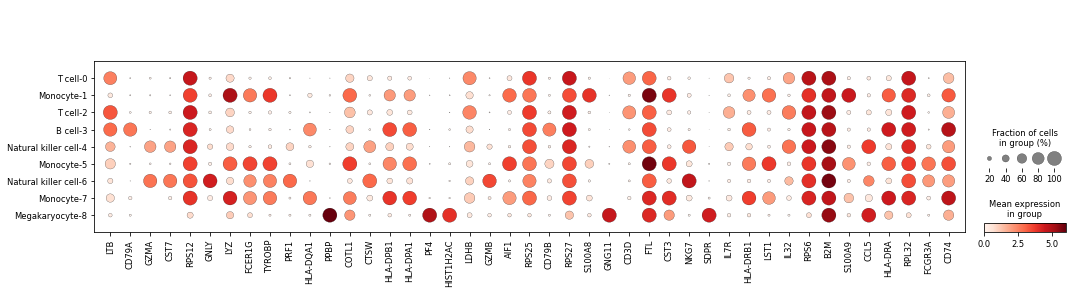

In [63]:
sc.pl.dotplot(adata, marker_genes, groupby='leiden');

#### Alternative view

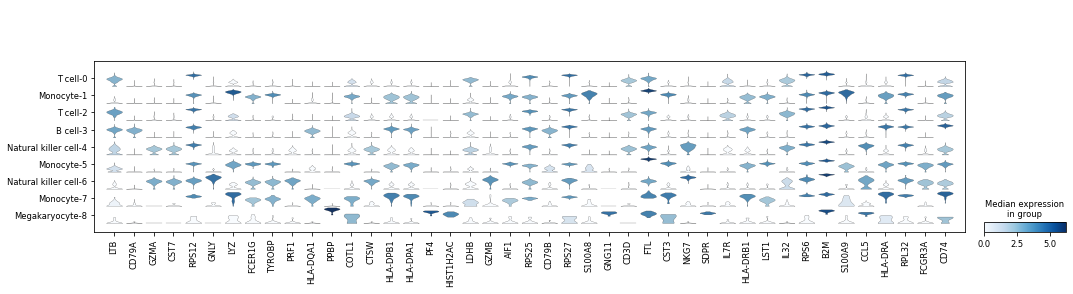

In [64]:
sc.pl.stacked_violin(adata, marker_genes, groupby='leiden', rotation=90)

#### Manual labeling

If there are not too many cell clusters and you have the domain knowledge, you can name them manually.

In [65]:
names = 'Santa Dasher Prancer Vixen Comet Cupid Donner Blitzen Rudolph'.split()
adata.rename_categories('louvain',  names)

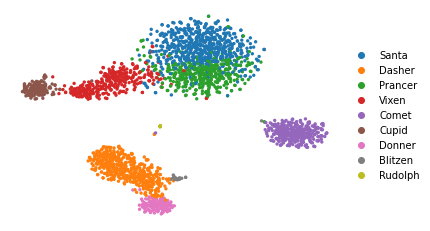

In [66]:
sc.pl.tsne(adata, 
           color='louvain', 
           legend_loc='right margin',
           title='', 
           frameon=False, 
           save='.pdf')

In [67]:
from sinfo import sinfo

sinfo()

-----
anndata     0.7.4
matplotlib  3.3.1
numpy       1.18.2
pandas      1.0.4
pyforest    1.0.3
scanpy      1.6.0
seaborn     0.11.0
sinfo       0.3.1
-----
IPython             7.18.1
jupyter_client      6.1.6
jupyter_core        4.6.3
jupyterlab          2.2.9
notebook            6.1.3
-----
Python 3.8.5 (default, Jul 21 2020, 10:48:26) [Clang 11.0.3 (clang-1103.0.32.62)]
macOS-10.16-x86_64-i386-64bit
12 logical CPU cores, i386
-----
Session information updated at 2021-04-22 00:01
